In [4]:
import os
import sys
from optparse import OptionParser

import numpy as np
import scipy as ci 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
# from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
import matplotlib 
%matplotlib inline 

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import tables 
import pickle
import warnings
from sklearn.externals import joblib
warnings.filterwarnings('once')

# Preliminary Distributions: global region

In [2]:
lifetime = 86400*365 # 1 year! 
fig_dir = '/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/plots/'

In [3]:
with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/corsika_h5/corsika_11057.h5','r') as f:
    n_file = 74909 # with _rf, the size of broken file is 266K instead of 0! y
    
    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] > 8
    CUT = CUT_dedx 
    
    chi2_red_corsika = f.root.Collection.cols.chi2_red[:][CUT]
    zenith_corsika = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_corsika = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
    NPE_corsika = f.root.QTot.cols.value[:][CUT]
    len_dedx_corsika = f.root.Collection.cols.len_dEdxVector[:][CUT]
    weight_corsika = f.root.Weight_GaisserH4a.cols.value[:][CUT] * lifetime/n_file 

with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/nugen_h5/nugen_11374.h5','r') as f:
    n_file = 19999

    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] > 8
    CUT = CUT_dedx 
    
    zenith_numu = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_numu = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
    len_dedx = f.root.Collection.cols.len_dEdxVector[:][CUT]

    ### astrophysical ###
    energy = f.root.MCPrimary_new.cols.energy[:][CUT]
    OneWeight = f.root.I3MCWeightDict.cols.OneWeight[:][CUT]
    NEvents = f.root.I3MCWeightDict.cols.NEvents[:][CUT]
    weight_numu_astro = (6.7 * 10**(-18))/6 * (energy/10**5)**(-2) * OneWeight/(n_file * NEvents) * lifetime * 2  # 10**5: 100 TeV. 2 is nu+nubar

with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/data_h5/data_burn.h5','r') as f:
    nfile_data = [2831731.134,3081951.304,3110722.657,3155703.188,3082765.564]
    
    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] > 8
    CUT = CUT_dedx 
    
    chi2_red_data_burn = f.root.Collection.cols.chi2_red[:][CUT]
    zenith_data_burn = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_data_burn = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
    NPE_data_burn = f.root.QTot.cols.value[:][CUT]
    len_dedx_data_burn = f.root.Collection.cols.len_dEdxVector[:][CUT]
    run_id_data_burn = f.root.I3EventHeader.cols.Run[:][CUT]
    event_id_data_burn = f.root.I3EventHeader.cols.Event[:][CUT]
    
    weight_data_burn = lifetime/np.sum(nfile_data) * np.ones(len(zenith_data_burn))
    

In [4]:
print(np.sum(weight_corsika))
print(np.sum(weight_data_burn))
print(np.sum(weight_data_burn)/np.sum(weight_corsika))

387811.3561243476
350675.86285868613
0.9042434093813531


[3.         3.21052632 3.42105263 3.63157895 3.84210526 4.05263158
 4.26315789 4.47368421 4.68421053 4.89473684 5.10526316 5.31578947
 5.52631579 5.73684211 5.94736842 6.15789474 6.36842105 6.57894737
 6.78947368 7.        ]


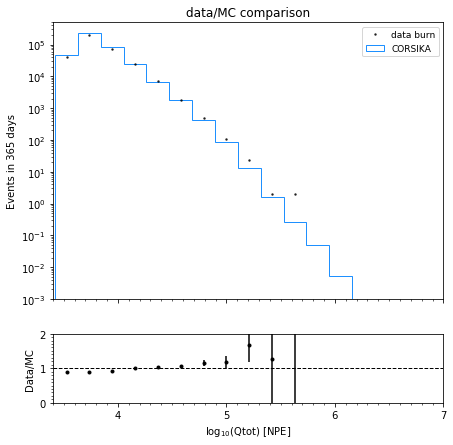

In [5]:
plt.figure(figsize=(7,7))

gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax1 = plt.subplot(gs[0])

h,b,p = plt.hist(np.log10(NPE_corsika),bins=np.linspace(3,7,20),log=True,histtype='step',lw=1,label='CORSIKA',weights=weight_corsika,bottom=10**(-6),color='dodgerblue')
hh,bb = np.histogram(np.log10(NPE_data_burn),bins=np.linspace(3,7,20),weights = weight_data_burn)
plt.plot((bb[1:]+bb[:-1])/2,hh,'.',ms=3,alpha=0.7,label='data burn',color='black')
print(b)
plt.ylabel('Events in 365 days')
plt.xlim(3.4,7)
plt.ylim(10**(-3),10**5.7)
plt.legend(prop={'size': 9})
plt.title('data/MC comparison')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax1.tick_params(labelbottom=False)    

def sumw2(h,b,weight,quantity):
    w_2 = []
    for i in range(0,len(b)-1):
        all_weight_in_bin = weight[(b[i]<quantity)&(quantity<b[i+1])]
        w_2.append(np.sum(all_weight_in_bin**2))
    return w_2

err_w = np.sqrt(sumw2(h,b,weight_corsika,np.log10(NPE_corsika)))
err_ww = np.sqrt(sumw2(hh,bb,weight_data_burn,np.log10(NPE_data_burn)))

ax2 = plt.subplot(gs[1])

h = h[hh > 0.]
bb = ((bb[1:]+bb[:-1])/2)[hh > 0.]
err_w = err_w[hh>0.]
err_ww = err_ww[hh>0.]
hh = hh[hh > 0.]
yerr = np.sqrt(err_ww**2/h**2 + hh**2/h**4*err_w**2)
plt.errorbar(bb, hh/h, yerr = yerr, fmt='o',ms=3,color='black',label='burn')

plt.axhline(1,ls='--',lw=1,color='black')

plt.xlabel(r'$\log_{10}($Qtot) [NPE]')
plt.ylabel('Data/MC')
plt.xlim(3.4,7)
plt.ylim(0,2)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax2.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax2.yaxis.set_major_locator(ticker.MultipleLocator(1.))
ax2.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in multiply


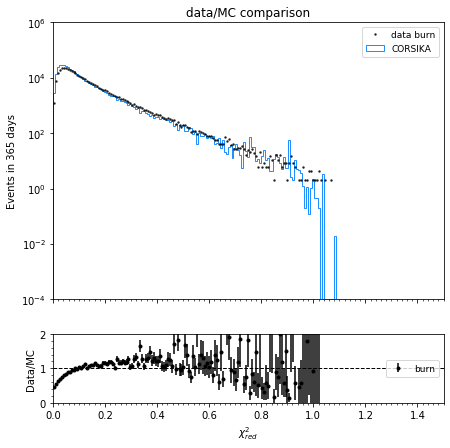

In [6]:
plt.figure(figsize=(7,7))

gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax1 = plt.subplot(gs[0])

h,b,p = plt.hist(chi2_red_corsika,bins=np.linspace(0,1.5,200),log=True,histtype='step',lw=1,label='CORSIKA',weights=weight_corsika,bottom=10**(-6),color='dodgerblue')
hh,bb = np.histogram(chi2_red_data_burn,bins=np.linspace(0,1.5,200),weights = weight_data_burn)
plt.plot((bb[1:]+bb[:-1])/2,hh,'.',ms=3,alpha=0.7,label='data burn',color='black')

def sumw2(h,b,weight,quantity):
    w_2 = []
    for i in range(0,len(b)-1):
        all_weight_in_bin = weight[(b[i]<quantity)&(quantity<b[i+1])]
        w_2.append(np.sum(all_weight_in_bin**2))
    return w_2

err_w = np.sqrt(sumw2(h,b,weight_corsika,chi2_red_corsika))
err_ww = np.sqrt(sumw2(hh,bb,weight_data_burn,chi2_red_data_burn))

plt.ylabel('Events in 365 days')
plt.xlim(0,1.5)
plt.ylim(10**(-4),10**6)
plt.legend(loc='best',prop={'size': 9})
plt.title('data/MC comparison')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(0.02))
ax1.tick_params(labelbottom=False)    

ax2 = plt.subplot(gs[1])

h = h[hh > 0.]
bb = ((bb[1:]+bb[:-1])/2)[hh > 0.]
err_w = err_w[hh>0.]
err_ww = err_ww[hh>0.]
hh = hh[hh > 0.]
yerr = np.sqrt(err_ww**2/h**2 + hh**2/h**4*err_w**2)
plt.errorbar(bb, hh/h, yerr = yerr, fmt='o',ms=3,color='black',label='burn')

plt.axhline(1,ls='--',lw=1,color='black')

plt.xlabel(r'$\chi^2_{red}$')
plt.ylabel('Data/MC')
plt.legend(loc='right',prop={'size': 9})
plt.xlim(0,1.5)
plt.ylim(0,2)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax2.xaxis.set_minor_locator(ticker.MultipleLocator(0.02))
ax2.yaxis.set_major_locator(ticker.MultipleLocator(1.))
ax2.yaxis.set_minor_locator(ticker.MultipleLocator(0.2))
plt.show()

In [7]:
print(*run_id_data_burn[chi2_red_data_burn>1.05],sep=',')
print(*event_id_data_burn[chi2_red_data_burn>1.05],sep=',')

123632
19585


# IT Ineff Small Region

In [8]:
# ineff model parameters 
params = np.loadtxt('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/IT_model.txt')
def ineff_model(dist,E): # E: log10 of energy!!! 

    a = params[0] + params[2] * (E + params[1])**2
    b = params[3] + params[5] * (E + params[4])**2
    val = 10 * a / dist**(1/3.) * np.exp( -10**6 * b / dist**2)
    
    val[val < 0.001] = 0.001 # This is arbitrary! 

    # low stat cut 
    val[E > 5.4+1.9*np.sqrt(1 - (dist)**2/2300**2)]=0.5
    val[dist>2200]=0.5
    return val

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


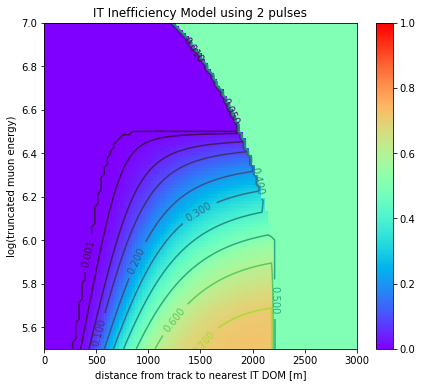

In [9]:
xt = np.linspace(0.001,3000,100) # dist 
yt = np.linspace(5.5,7,100)  # E 
xg,yg = np.meshgrid(xt,yt)
zg = ineff_model(xg,yg)

plt.figure(figsize=(7,6))
plt.pcolormesh(xg,yg,zg,cmap='rainbow',shading='flat')
plt.colorbar()
plt.clim(0,1) # colorbar limit
CS=plt.contour(xg,yg,zg,levels=[0.001,0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
plt.clabel(CS,inline=1,fmt='%1.3f',fontsize=10)
plt.xlabel('distance from track to nearest IT DOM [m]')
plt.ylabel('log(truncated muon energy)')
plt.xlim(0,3000)
plt.ylim(5.5,7)
plt.title('IT Inefficiency Model using 2 pulses')
plt.show()

# Check IT Validity

In [12]:
IT_ineff_cut = 0.01
E_min = 1
E_max = 9.
Z_min = 0.
Z_max = 1

with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/data_h5/data_burn.h5','r') as f:
    nfile_data = [2831731.134,3081951.304,3110722.657,3155703.188,3082765.564]
    
    ineff_data_burn = ineff_model(f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))
    CUT_ineff = ineff_data_burn < IT_ineff_cut
#     CUT_phase = (np.cos(f.root.SplineMPE.cols.zenith[:])-0.95)**2/0.03**2+\
#                 (np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:])-5.82)**2/0.08**2 > 1
    CUT_truncated_bin = (np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:])>E_min) & (np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:])<E_max)
    CUT_zenith = (np.cos(f.root.SplineMPE.cols.zenith[:])>Z_min)&(np.cos(f.root.SplineMPE.cols.zenith[:])<Z_max)
    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] > 4

    CUT = CUT_ineff & CUT_truncated_bin & CUT_zenith & CUT_dedx

    ineff_data_burn = ineff_data_burn[CUT]
    
    # IT hits in different windows
    num_corr_total_in = f.root.IT_veto_double.cols.num_correlated_Total_hits_in_window[:][CUT]
    num_corr_total_off = f.root.IT_veto_double.cols.num_correlated_Total_hits_off_window[:][CUT]

    # all delta t
    delta_t_hlc = f.root.IT_veto_vector_delta_t_HLC.cols.item[:]
    delta_t_slc = f.root.IT_veto_vector_delta_t_SLC.cols.item[:]

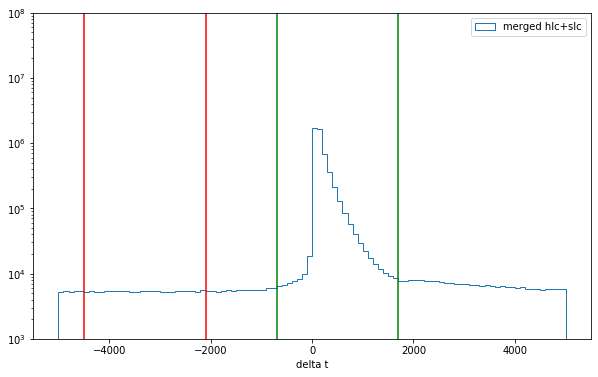

In [19]:
plt.figure(figsize=(10,6))
# plt.hist(delta_t_hlc,bins=np.arange(-5000,5100,100),histtype='step',log=True,density=True,label='hlc')
# plt.hist(delta_t_slc,bins=np.arange(-5000,5100,100),histtype='step',log=True,density=True,label='slc')
plt.hist(np.concatenate((delta_t_slc,delta_t_hlc)),bins=np.arange(-5000,5100,100),histtype='step',log=True,label='merged hlc+slc')

plt.axvline(-700,color='g')
plt.axvline(1700,color='g')
plt.axvline(-4500,color='r')
plt.axvline(-2100,color='r')

plt.ylim(10**3,10**8)
plt.xlabel('delta t')
plt.legend()
plt.show()

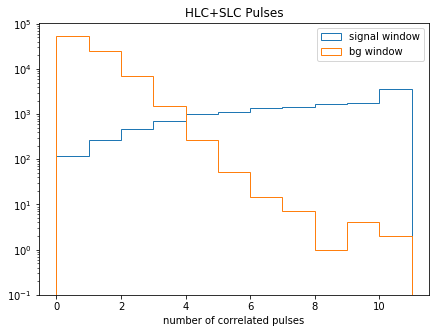

In [12]:
# zen_cut = 0.98
plt.figure(figsize=(7,5))
plt.hist(num_corr_total_in,bins=np.arange(0,12,1),log=True,histtype='step',label='signal window')
plt.hist(num_corr_total_off,bins=np.arange(0,12,1),log=True,histtype='step',label='bg window ')
plt.xlabel('number of correlated pulses')
plt.title('HLC+SLC Pulses')
plt.legend()
plt.show()

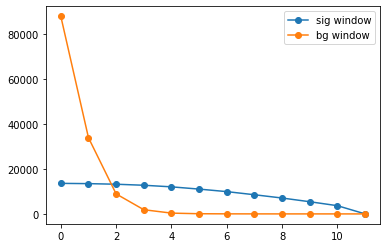

In [13]:
n = np.arange(0,12,1)
h_in,b_in = np.histogram(num_corr_total_in,bins=np.arange(0,12,1))
h_off,b_off = np.histogram(num_corr_total_off,bins=np.arange(0,12,1))
b_in = (b_in[1:]+b_in[:-1])/2
b_off = (b_off[1:]+b_off[:-1])/2

inwindow = []
offwindow = []
for i in n:
    inwindow.append( np.sum(h_in[b_in>i]) )
    offwindow.append( np.sum(h_off[b_off>i]) )
plt.plot(n,inwindow,'o-',label='sig window')
plt.plot(n,offwindow,'o-',label='bg window')
plt.legend()
plt.show()

# data/MC

In [14]:
IT_ineff_cut = 0.01
E_min = 1
E_max = 9
Z_min = 0.
Z_max = 1

# with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/corsika_h5/corsika_11057.h5','r') as f:
#     n_file = 74909 # with _rf, the size of broken file is 266K instead of 0! 
    
with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/corsika_h5/corsika_11937.h5','r') as f:
    n_file = 60253 # with _rf, the size of broken file is 266K instead of 0! 

    ineff_corsika = ineff_model(f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))
    CUT_ineff = ineff_corsika < IT_ineff_cut
    CUT_truncated = (np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:])>E_min) & (np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:])<E_max)
    CUT_zenith = (np.cos(f.root.SplineMPE.cols.zenith[:])>Z_min)&(np.cos(f.root.SplineMPE.cols.zenith[:])<Z_max)
    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] > 4
#     CUT_llh = f.root.CascadeLlhVertexFitParams.cols.rlogL[:] < 18 # remove coincident events! 
#     CUT_coincident = f.root.MCPrimary_coincident.cols.value[:] == 0.
    
    CUT = CUT_ineff & CUT_truncated & CUT_zenith & CUT_dedx #  & CUT_llh

    chi2_red_corsika = f.root.Collection.cols.chi2_red[:][CUT]
    PeakOverMedian_corsika = f.root.Collection.cols.PeakOverMedian[:][CUT]
    zenith_corsika = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_corsika = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
    NPE_corsika = f.root.QTot.cols.value[:][CUT]
    llh_corsika = f.root.CascadeLlhVertexFitParams.cols.rlogL[:][CUT]
    dedxlen_corsika = f.root.Collection.cols.len_dEdxVector[:][CUT]
    coincidence_corsika = f.root.MCPrimary_coincident.cols.value[:][CUT]
    
    
    fileid = f.root.FileNumber.cols.value[:][CUT]
    eventid = f.root.I3EventHeader.cols.Event[:][CUT]
    weight_corsika = f.root.Weight_GaisserH4a.cols.value[:][CUT] * lifetime/n_file # * 903098/363528
    
with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/data_h5/data_burn.h5','r') as f:
    nfile_data = [2831731.134,3081951.304,3110722.657,3155703.188,3082765.564]
    
    ineff_data_burn = ineff_model(f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))
    CUT_ineff = ineff_data_burn < IT_ineff_cut
    CUT_truncated = (np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:])>E_min) & (np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:])<E_max)
    CUT_zenith = (np.cos(f.root.SplineMPE.cols.zenith[:])>Z_min)&(np.cos(f.root.SplineMPE.cols.zenith[:])<Z_max)
    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] > 4
#     CUT_llh = f.root.CascadeLlhVertexFitParams.cols.rlogL[:] < 18

    C_tag = (1-f.root.IT_veto_double.cols.flag_window_2[:]).astype(bool) # events that are rejected.
    C_untag = (f.root.IT_veto_double.cols.flag_window_2[:]).astype(bool) # events pass the veto (not rejected). NOTE: Need to convert to BOOL type!! 

    CUT = CUT_ineff & CUT_truncated & CUT_zenith & CUT_dedx #& CUT_llh
    CUT_tag = CUT_ineff & CUT_truncated & CUT_zenith & CUT_dedx & C_tag
    CUT_untag = CUT_ineff & CUT_truncated & CUT_zenith & CUT_dedx & C_untag
    
    chi2_red_data_burn = f.root.Collection.cols.chi2_red[:][CUT]
    PeakOverMedian_data_burn = f.root.Collection.cols.PeakOverMedian[:][CUT]
    zenith_data_burn = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_data_burn = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
    NPE_data_burn = f.root.QTot.cols.value[:][CUT]
    llh_data_burn = f.root.CascadeLlhVertexFitParams.cols.rlogL[:][CUT]
    dedxlen_data_burn = f.root.Collection.cols.len_dEdxVector[:][CUT]

    chi2_red_data_burn_tag = f.root.Collection.cols.chi2_red[:][CUT_tag]
    PeakOverMedian_data_burn_tag = f.root.Collection.cols.PeakOverMedian[:][CUT_tag]
    zenith_data_burn_tag = f.root.SplineMPE.cols.zenith[:][CUT_tag]
    truncated_muon_e_data_burn_tag = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT_tag]
    NPE_data_burn_tag = f.root.QTot.cols.value[:][CUT_tag]

    chi2_red_data_burn_untag = f.root.Collection.cols.chi2_red[:][CUT_untag]
    PeakOverMedian_data_burn_untag = f.root.Collection.cols.PeakOverMedian[:][CUT_untag]
    zenith_data_burn_untag = f.root.SplineMPE.cols.zenith[:][CUT_untag]
    truncated_muon_e_data_burn_untag = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT_untag]
    NPE_data_burn_untag = f.root.QTot.cols.value[:][CUT_untag]
    
    eventid_data_burn = f.root.I3EventHeader.cols.Event[:][CUT]
    runid_data_burn = f.root.I3EventHeader.cols.Run[:][CUT]
    
    weight_data_burn = lifetime/np.sum(nfile_data) * np.ones(len(zenith_data_burn))
    weight_data_burn_tag = lifetime/np.sum(nfile_data) * np.ones(len(zenith_data_burn_tag)) * np.sum(CUT)/np.sum(CUT_tag)
    weight_data_burn_untag = lifetime/np.sum(nfile_data) *np.sum(CUT)/np.sum(CUT_untag) * np.ones(len(zenith_data_burn_untag))

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


In [16]:
# f = tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/corsika_h5/corsika_11937.h5','r')
# print(f.root.FileNumber.cols.value[:100])
# print(f.root.I3EventHeader.cols.Event[:100])

# f.rot.
# # f.root.

### For CascadeLlh, 
the reduced
likelihood rlogl defined as a ratio of the logarithm of the
likelihood and the number of degrees of freedom was calculated. Smaller values of rlogl indicate consistency with
the cascade-like hypothesis and this helps to separate signal
and background

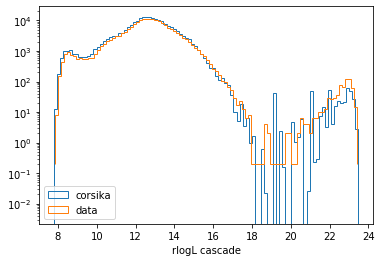

In [17]:
plt.hist(llh_corsika,bins=100,histtype='step',weights=weight_corsika,log=True,label='corsika')
plt.hist(llh_data_burn,bins=100,histtype='step',weights=weight_data_burn,log=True,label='data')
plt.legend()
plt.xlabel('rlogL cascade')
plt.show()

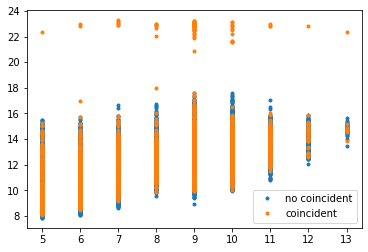

In [18]:
n = 5
plt.plot(dedxlen_corsika[coincidence_corsika==0][::n], llh_corsika[coincidence_corsika==0][::n],'.',label='no coincident')
plt.plot(dedxlen_corsika[coincidence_corsika==1][::n], llh_corsika[coincidence_corsika==1][::n],'.',label='coincident')
plt.legend()
plt.show()

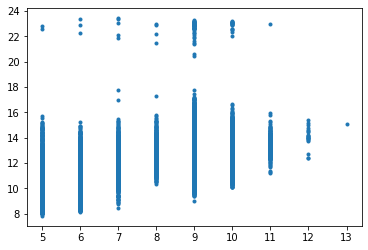

In [19]:
plt.plot(dedxlen_data_burn[::n], llh_data_burn[::n],'.',label='no coincident')


In [20]:
print(*eventid_data_burn[llh_data_burn>23.2],sep=',')
print(*runid_data_burn[llh_data_burn>23.2].astype(int),sep=',') # runid 

print(*eventid[llh_corsika>23.2],sep=',')
print(*fileid[llh_corsika>23.2].astype(int),sep=',') # runid 

360189,37058128,14722178,6710116,35312987,6805513,41789605,66473624,51358469,50565378,50660441,28700267,46541819,28980976,3847627
120803,123069,123596,125468,125789,126183,126191,126686,126838,128244,128321,128763,128974,129339,129346
1971,1904,4181,4104,2513,4125,1320,4392,25,896,3087,4118,2491,985,1291,4036,4029,1843,3812,3869,2472
2412,2476,4871,5072,8275,10901,11949,15124,21286,26392,26906,28200,33523,35192,35472,39870,44420,45743,50799,55183,59908


In [21]:
print(*eventid_data_burn[llh_data_burn<8],sep=',')
print(*runid_data_burn[llh_data_burn<8].astype(int),sep=',') # runid 
print('-- corsika --')
print(*eventid[llh_corsika<7.9],sep=',')
print(*fileid[llh_corsika<7.9].astype(int),sep=',') # runid 

62800310,63364603,67961,48465470,72595719,37359176,77348923,60615845
123181,125054,125179,125484,125517,125736,125966,128937
-- corsika --
1623,4220,2556,3227,2941,4373,2658,1977
3688,9282,9710,13731,27217,47346,49231,54035


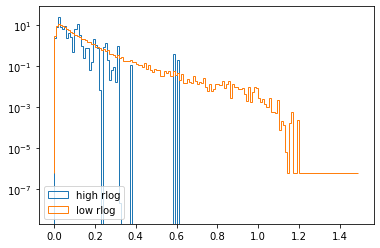

In [22]:
plt.hist(chi2_red_corsika[llh_corsika>20],bins=np.arange(0,1.5,0.01),weights=weight_corsika[llh_corsika>20],log=True,density=True,histtype='step',label='high rlog')
plt.hist(chi2_red_corsika[llh_corsika<18],bins=np.arange(0,1.5,0.01),weights=weight_corsika[llh_corsika<18],log=True,density=True,histtype='step',label='low rlog')
plt.legend()
plt.show()

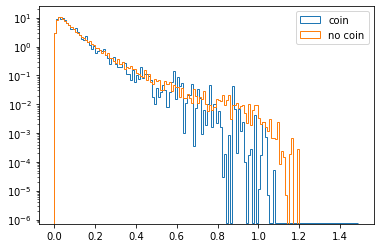

In [23]:
plt.hist(chi2_red_corsika[coincidence_corsika==1],bins=np.arange(0,1.5,0.01),weights=weight_corsika[coincidence_corsika==1],log=True,density=True,histtype='step',label='coin')
plt.hist(chi2_red_corsika[coincidence_corsika==0],bins=np.arange(0,1.5,0.01),weights=weight_corsika[coincidence_corsika==0],log=True,density=True,histtype='step',label='no coin')
plt.legend()
plt.show()

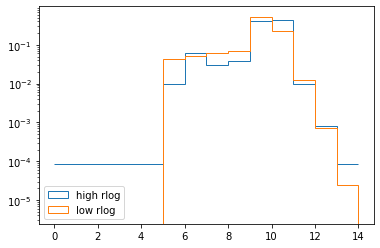

In [24]:
plt.hist(dedxlen_corsika[llh_corsika>20],bins=np.arange(0,15,1),weights=weight_corsika[llh_corsika>20],log=True,density=True,histtype='step',label='high rlog')
plt.hist(dedxlen_corsika[llh_corsika<18],bins=np.arange(0,15,1),weights=weight_corsika[llh_corsika<18],log=True,density=True,histtype='step',label='low rlog')
plt.legend()
plt.show()

In [127]:
np.sum(coincidence_corsika[cascllh_corsika>20])/len(coincidence_corsika[cascllh_corsika>20])

0.9977272727272727

In [129]:
np.sum(coincidence_corsika)/len(coincidence_corsika)

0.09636391609826145

In [128]:
np.sum(coincidence_corsika[cascllh_corsika<18])/len(coincidence_corsika[cascllh_corsika<18])

0.09506796989102348

In [103]:
len((coincidence_corsika[cascllh_corsika<18])[coincidence_corsika[cascllh_corsika<18]==1])

29617

In [104]:
len((coincidence_corsika[cascllh_corsika>20])[coincidence_corsika[cascllh_corsika>20]==1])

439

In [93]:
print(np.sum(weight_corsika))
print(np.sum(weight_data_burn),np.sum(CUT))
print(np.sum(weight_data_burn_tag),np.sum(CUT_tag))
print(np.sum(weight_data_burn_untag),np.sum(CUT_untag))
print(np.sum(CUT_tag)/np.sum(CUT))
print(np.sum(CUT_untag)/np.sum(CUT))

207366.4242151819
189033.6730108727 91489
189033.6730108728 91376
189033.6730108728 430
0.9987648788378931
0.004700018581468811


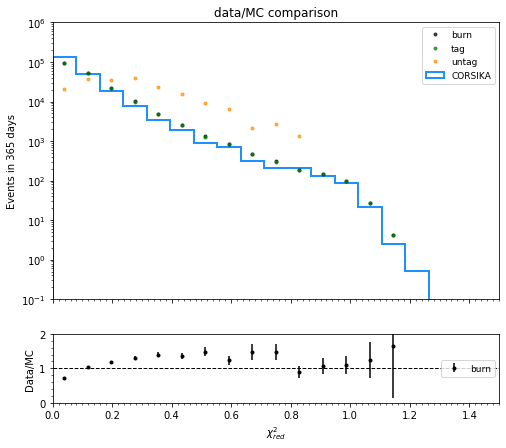

In [158]:
plt.figure(figsize=(8,7))

gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax1 = plt.subplot(gs[0])

h,b,p = plt.hist(chi2_red_corsika,bins=np.linspace(0,1.5,20),log=True,histtype='step',lw=2,label='CORSIKA',weights=weight_corsika,bottom=10**(-6),color='dodgerblue')
hh,bb = np.histogram(chi2_red_data_burn,bins=np.linspace(0,1.5,20),weights = weight_data_burn)
hh_tag,bb_tag = np.histogram(chi2_red_data_burn_tag,bins=np.linspace(0,1.5,20),weights = weight_data_burn_tag)
hh_untag,bb_untag = np.histogram(chi2_red_data_burn_untag,bins=np.linspace(0,1.5,20),weights = weight_data_burn_untag)

plt.plot((bb[1:]+bb[:-1])/2,hh,'o',ms=3,alpha=0.7,label='burn',color='black')
plt.plot((bb_tag[1:]+bb_tag[:-1])/2,hh_tag,'o',ms=3,alpha=0.7,label='tag',color='g')
plt.plot((bb_untag[1:]+bb_untag[:-1])/2,hh_untag,'o',ms=3,alpha=0.7,label='untag',color='darkorange')

def sumw2(h,b,weight,quantity):
    w_2 = []
    for i in range(0,len(b)-1):
        all_weight_in_bin = weight[(b[i]<quantity)&(quantity<b[i+1])]
        w_2.append(np.sum(all_weight_in_bin**2))
    return w_2

err_w = np.sqrt(sumw2(h,b,weight_corsika,chi2_red_corsika))
err_ww = np.sqrt(sumw2(hh,bb,weight_data_burn,chi2_red_data_burn))

plt.ylabel('Events in 365 days')
plt.xlim(0,1.5)
plt.ylim(10**(-1),10**6)
plt.legend(loc='best',prop={'size': 9})
plt.title('data/MC comparison')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(0.02))
ax1.tick_params(labelbottom=False)    

ax2 = plt.subplot(gs[1])

h = h[hh > 0.]
bb = ((bb[1:]+bb[:-1])/2)[hh > 0.]
err_w = err_w[hh>0.]
err_ww = err_ww[hh>0.]
hh = hh[hh > 0.]
yerr = np.sqrt(err_ww**2/h**2 + hh**2/h**4*err_w**2)
plt.errorbar(bb, hh/h, yerr = yerr, fmt='o',ms=3,color='black',label='burn')

plt.axhline(1,ls='--',lw=1,color='black')

plt.xlabel(r'$\chi^2_{red}$')
plt.ylabel('Data/MC')
plt.legend(loc='right',prop={'size': 9})
plt.xlim(0,1.5)
plt.ylim(0,2)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax2.xaxis.set_minor_locator(ticker.MultipleLocator(0.02))
ax2.yaxis.set_major_locator(ticker.MultipleLocator(1.))
ax2.yaxis.set_minor_locator(ticker.MultipleLocator(0.2))

In [113]:
h[0]-hh[0]

28368.245360862915

# Adjust Weight

In [46]:
def num_to_mass(x):
    x[x==2212] = 1
    x[x==1000020040] = 4
    x[x==1000070140] = 14
    x[x==1000130270] = 27
    x[x==1000260560] = 56
    return x

In [47]:
# 1st 

with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/corsika_h5/corsika_11057.h5','r') as f:
    n_file = 74909 

    ineff_corsika = ineff_model(f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))
    CUT_ineff = ineff_corsika < IT_ineff_cut
    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] > 4
    
    CUT = CUT_ineff & CUT_dedx #& CUT_coincident

    CUT_all_PPlus = f.root.MCPrimary_new.cols.type[:][CUT] == 2212
    CUT_all_He = f.root.MCPrimary_new.cols.type[:][CUT] == 1000020040
    CUT_all_N= f.root.MCPrimary_new.cols.type[:][CUT] == 1000070140
    CUT_all_Al = f.root.MCPrimary_new.cols.type[:][CUT] == 1000130270
    CUT_all_Fe = f.root.MCPrimary_new.cols.type[:][CUT] == 1000260560

    A = num_to_mass(f.root.MCPrimary_new.cols.type[:][CUT])
    
    chi2_red_corsika = f.root.Collection.cols.chi2_red[:][CUT]
    chi2_red_corsika_all_PPlus = chi2_red_corsika[CUT_all_PPlus]
    chi2_red_corsika_all_He = chi2_red_corsika[CUT_all_He]
    chi2_red_corsika_all_N = chi2_red_corsika[CUT_all_N]
    chi2_red_corsika_all_Al = chi2_red_corsika[CUT_all_Al]
    chi2_red_corsika_all_Fe = chi2_red_corsika[CUT_all_Fe]

#     PeakOverMedian_corsika = f.root.Collection.cols.PeakOverMedian[:][CUT]
#     PeakOverMedian_corsika_all_PPlus = PeakOverMedian_corsika[CUT_all_PPlus]
#     PeakOverMedian_corsika_all_He = PeakOverMedian_corsika[CUT_all_He]
#     PeakOverMedian_corsika_all_N = PeakOverMedian_corsika[CUT_all_N]
#     PeakOverMedian_corsika_all_Al = PeakOverMedian_corsika[CUT_all_Al]
#     PeakOverMedian_corsika_all_Fe = PeakOverMedian_corsika[CUT_all_Fe]

#     truncated_muon_e_corsika = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
#     truncated_muon_e_corsika_all_PPlus = truncated_muon_e_corsika[CUT_all_PPlus]
#     truncated_muon_e_corsika_all_He = truncated_muon_e_corsika[CUT_all_He]
#     truncated_muon_e_corsika_all_N = truncated_muon_e_corsika[CUT_all_N]
#     truncated_muon_e_corsika_all_Al = truncated_muon_e_corsika[CUT_all_Al]
#     truncated_muon_e_corsika_all_Fe = truncated_muon_e_corsika[CUT_all_Fe]

#     zenith_corsika = f.root.SplineMPE.cols.zenith[:][CUT]
#     zenith_corsika_all_PPlus = zenith_corsika[CUT_all_PPlus]
#     zenith_corsika_all_He = zenith_corsika[CUT_all_He]
#     zenith_corsika_all_N = zenith_corsika[CUT_all_N]
#     zenith_corsika_all_Al = zenith_corsika[CUT_all_Al]
#     zenith_corsika_all_Fe = zenith_corsika[CUT_all_Fe]
    
    primary_energy_corsika = f.root.MCPrimary_new.cols.energy[:][CUT]
#     primary_energy_corsika_all_PPlus = primary_energy_corsika[CUT_all_PPlus]
#     primary_energy_corsika_all_He = primary_energy_corsika[CUT_all_He]
#     primary_energy_corsika_all_N = primary_energy_corsika[CUT_all_N]
#     primary_energy_corsika_all_Al = primary_energy_corsika[CUT_all_Al]
#     primary_energy_corsika_all_Fe = primary_energy_corsika[CUT_all_Fe]

#     Qtot_corsika = f.root.QTot.cols.value[:][CUT]
#     Qtot_corsika_all_PPlus = Qtot_corsika[CUT_all_PPlus]
#     Qtot_corsika_all_He = Qtot_corsika[CUT_all_He]
#     Qtot_corsika_all_N = Qtot_corsika[CUT_all_N]
#     Qtot_corsika_all_Al = Qtot_corsika[CUT_all_Al]
#     Qtot_corsika_all_Fe = Qtot_corsika[CUT_all_Fe]

    weight_orig = f.root.Weight_GaisserH3a.cols.value[:][CUT] * lifetime/n_file 
    print(weight_orig)
    adjusted = f.root.Weight_GaisserH3a.cols.value[:][CUT] * (1 + 70/(A+1)**(1) * (8/(8+np.log10(primary_energy_corsika)))**2 ) 
    print(adjusted)
    weight_corsika = np.sum(weight_orig) * adjusted/np.sum(adjusted) 
    print(weight_corsika)
#     weight_corsika = f.root.Weight_GaisserH4a.cols.value[:][CUT] * lifetime/n_file 
    weight_corsika_all_PPlus = weight_corsika[CUT_all_PPlus] * np.sum(weight_orig)/np.sum(weight_corsika[CUT_all_PPlus])
    weight_corsika_all_He = weight_corsika[CUT_all_He] * np.sum(weight_orig)/np.sum(weight_corsika[CUT_all_He])
    weight_corsika_all_N = weight_corsika[CUT_all_N] * np.sum(weight_orig)/np.sum(weight_corsika[CUT_all_N])
    weight_corsika_all_Al = weight_corsika[CUT_all_Al] * np.sum(weight_orig)/np.sum(weight_corsika[CUT_all_Al])
    weight_corsika_all_Fe = weight_corsika[CUT_all_Fe] * np.sum(weight_orig)/np.sum(weight_corsika[CUT_all_Fe])


/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


[2.92063476e-03 1.14537588e-03 1.30372452e+00 ... 4.35931690e-03
 8.86576972e-03 8.83250428e-01]
[6.17202787e-05 2.31859770e-05 5.22444014e-03 ... 4.18909623e-05
 4.29050634e-05 3.49646634e-03]
[0.01244712 0.00467591 1.05361233 ... 0.00844815 0.00865266 0.70513203]


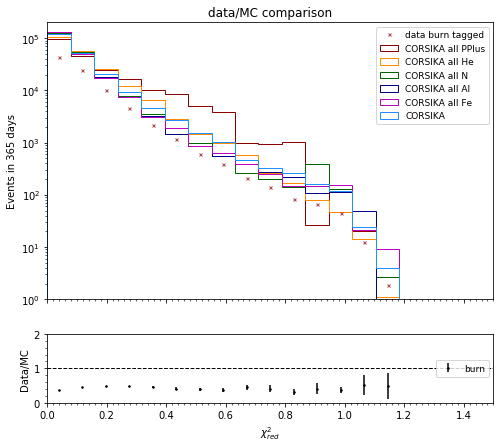

In [49]:
# 3rd 

plt.figure(figsize=(8,7))

gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax1 = plt.subplot(gs[0])

# h_a,b_a,p_a = plt.hist(chi2_red_corsika,bins=np.arange(0,1.5,0.02),log=True,histtype='step',lw=1,label='CORSIKA adjusted',weights=weight_corsika_adjusted,bottom=10**(-6),color='red')

plt.hist(chi2_red_corsika_all_PPlus,bins=np.linspace(0,1.5,20),log=True,histtype='step',lw=1,label='CORSIKA all PPlus',weights=weight_corsika_all_PPlus,bottom=10**(-6),color='darkred')
plt.hist(chi2_red_corsika_all_He,bins=np.linspace(0,1.5,20),log=True,histtype='step',lw=1,label='CORSIKA all He',weights=weight_corsika_all_He,bottom=10**(-6),color='darkorange')
plt.hist(chi2_red_corsika_all_N,bins=np.linspace(0,1.5,20),log=True,histtype='step',lw=1,label='CORSIKA all N',weights=weight_corsika_all_N,bottom=10**(-6),color='darkgreen')
plt.hist(chi2_red_corsika_all_Al,bins=np.linspace(0,1.5,20),log=True,histtype='step',lw=1,label='CORSIKA all Al',weights=weight_corsika_all_Al,bottom=10**(-6),color='darkblue')
plt.hist(chi2_red_corsika_all_Fe,bins=np.linspace(0,1.5,20),log=True,histtype='step',lw=1,label='CORSIKA all Fe',weights=weight_corsika_all_Fe,bottom=10**(-6),color='m')
h,b,p = plt.hist(chi2_red_corsika,bins=np.linspace(0,1.5,20),log=True,histtype='step',lw=1,label='CORSIKA',weights=weight_corsika,bottom=10**(-6),color='dodgerblue')

hh,bb = np.histogram(chi2_red_data_burn_tag,bins=np.linspace(0,1.5,20),weights = weight_data_burn_tag)
plt.plot((bb[1:]+bb[:-1])/2,hh,'x',ms=3,alpha=0.7,label='data burn tagged',color='darkred')
# hh_ut,bb_ut = np.histogram(chi2_red_data_burn_untag,bins=np.arange(0,1.5,0.02),weights = weight_data_burn_untag)
# plt.plot((bb_ut[1:]+bb_ut[:-1])/2,hh_ut,'+',ms=3,alpha=0.7,label='data burn untag',color='darkgreen')
# hh,bb = np.histogram(chi2_red_data_burn,bins=np.linspace(0,1.5,50),weights = weight_data_burn)
# plt.plot((bb[1:]+bb[:-1])/2,hh,'.',ms=3,alpha=0.7,label='data burn',color='black')

plt.ylabel('Events in 365 days')
plt.xlim(0,1.5)
plt.ylim(10**0,10**5.3)
plt.legend(loc='best',prop={'size': 9})
plt.title('data/MC comparison')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(0.02))
ax1.tick_params(labelbottom=False)    

ax2 = plt.subplot(gs[1])
err_w = np.sqrt(sumw2(h,b,weight_corsika,chi2_red_corsika))
err_ww = np.sqrt(sumw2(hh,bb,weight_data_burn,chi2_red_data_burn))

h = h[hh > 0.]
bb = ((bb[1:]+bb[:-1])/2)[hh > 0.]
err_w = err_w[hh>0.]
err_ww = err_ww[hh>0.]
hh = hh[hh > 0.]
yerr = np.sqrt(err_ww**2/h**2 + hh**2/h**4*err_w**2)
plt.errorbar(bb, hh/h, yerr = yerr, fmt='.',ms=3,color='black',label='burn')

plt.axhline(1,ls='--',lw=1,color='black')

plt.xlabel(r'$\chi^2_{red}$')
plt.ylabel('Data/MC')
plt.legend(loc='right',prop={'size': 9})
plt.xlim(0,1.5)
plt.ylim(0,2)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax2.xaxis.set_minor_locator(ticker.MultipleLocator(0.02))
ax2.yaxis.set_major_locator(ticker.MultipleLocator(1.))
ax2.yaxis.set_minor_locator(ticker.MultipleLocator(0.2))

In [50]:
# 2nd  

with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/data_h5/data_burn.h5','r') as f:
    nfile_data = [2831731.134,3081951.304,3110722.657,3155703.188,3082765.564] # Feb.11, 2020

    ineff_data_burn = ineff_model(f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))
    CUT_ineff = ineff_data_burn < IT_ineff_cut
    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] > 4
    
    C_tag = (1-f.root.IT_veto_double.cols.flag_window_2[:]).astype(bool) # events that are rejected.
    C_untag = (f.root.IT_veto_double.cols.flag_window_2[:]).astype(bool) # events pass the veto (not rejected). NOTE: Need to convert to BOOL type!! 

    CUT = CUT_ineff & CUT_dedx 
    CUT_tag = CUT_ineff & CUT_dedx & C_tag
    CUT_untag = CUT_ineff & CUT_dedx & C_untag
    
    rejected_2_data_burn = ((1 - f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool))  # background (muon bundle) events!

#     chi2_data_burn = f.root.Collection.cols.chi2[:][CUT]
#     ndf_data_burn = f.root.Collection.cols.NDF[:][CUT]
#     chi2_red_data_burn = chi2_data_burn/ndf_data_burn
#     PeakOverMedian_data_burn = f.root.Collection.cols.PeakOverMedian[:][CUT]
#     zenith_data_burn = f.root.SplineMPE.cols.zenith[:][CUT]
#     truncated_muon_e_data_burn = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
#     Qtot_data_burn = f.root.QTot.cols.value[:][CUT]

    chi2_red_data_burn_tag = f.root.Collection.cols.chi2_red[:][CUT_tag]
    PeakOverMedian_data_burn_tag = f.root.Collection.cols.PeakOverMedian[:][CUT_tag]
    zenith_data_burn_tag = f.root.SplineMPE.cols.zenith[:][CUT_tag]
    truncated_muon_e_data_burn_tag = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT_tag]
    Qtot_data_burn_tag = f.root.QTot.cols.value[:][CUT_tag]

#     chi2_red_data_burn_untag = f.root.Collection.cols.chi2_red[:][CUT_untag]
#     PeakOverMedian_data_burn_untag = f.root.Collection.cols.PeakOverMedian[:][CUT_untag]
#     zenith_data_burn_untag = f.root.SplineMPE.cols.zenith[:][CUT_untag]
#     truncated_muon_e_data_burn_untag = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT_untag]
#     Qtot_data_burn_untag = f.root.QTot.cols.value[:][CUT_untag]

#     weight_data_burn = lifetime/np.sum(nfile_data) * np.ones(len(chi2_red_data_burn)) 
    weight_data_burn_tag = lifetime/np.sum(nfile_data) * np.ones(len(zenith_data_burn_tag)) * np.sum(CUT)/np.sum(CUT_tag)
#     weight_data_burn_untag = lifetime/np.sum(nfile_data) * np.ones(len(chi2_red_data_burn_untag)) * len(weight_data_burn)/len(chi2_red_data_burn_untag)


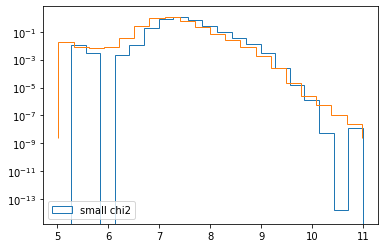

In [40]:
plt.hist(np.log10(primary_energy_corsika)[chi2_red_corsika<0.03],bins=20,log=True,density=True,weights=weight_corsika[chi2_red_corsika<0.03],histtype='step',label='small chi2')
plt.hist(np.log10(primary_energy_corsika)[chi2_red_corsika>0.03],bins=20,log=True,density=True,weights=weight_corsika[chi2_red_corsika>0.03],histtype='step')
plt.legend()
plt.show()

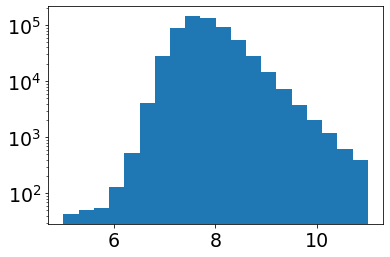

In [228]:
plt.hist(np.log10(primary_energy_corsika)[chi2_red_corsika>0.03],bins=20,log=True)
plt.show()

# Try different chi2 calculation

In [8]:
# 1st 
# mat_corsika = np.zeros((70981,15))

lifetime = 365*86400 
with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/corsika_h5/corsika_11057.h5','r') as f:
    n_file = 74909

    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:][::10] > 6
    
    CUT = CUT_dedx #& CUT_coincident
    
    mat_corsika = np.zeros((np.sum(CUT),15))

    mat_corsika[:,0] = f.root.Collection.cols.EnergyLoss_0[:][::10][CUT]
    mat_corsika[:,1] = f.root.Collection.cols.EnergyLoss_1[:][::10][CUT]
    mat_corsika[:,2] = f.root.Collection.cols.EnergyLoss_2[:][::10][CUT]
    mat_corsika[:,3] = f.root.Collection.cols.EnergyLoss_3[:][::10][CUT]
    mat_corsika[:,4] = f.root.Collection.cols.EnergyLoss_4[:][::10][CUT]
    mat_corsika[:,5] = f.root.Collection.cols.EnergyLoss_5[:][::10][CUT]
    mat_corsika[:,6] = f.root.Collection.cols.EnergyLoss_6[:][::10][CUT]
    mat_corsika[:,7] = f.root.Collection.cols.EnergyLoss_7[:][::10][CUT]
    mat_corsika[:,8] = f.root.Collection.cols.EnergyLoss_8[:][::10][CUT]
    mat_corsika[:,9] = f.root.Collection.cols.EnergyLoss_9[:][::10][CUT]
    mat_corsika[:,10] = f.root.Collection.cols.EnergyLoss_10[:][::10][CUT]
    mat_corsika[:,11] = f.root.Collection.cols.EnergyLoss_11[:][::10][CUT]
    mat_corsika[:,12] = f.root.Collection.cols.EnergyLoss_12[:][::10][CUT]
    mat_corsika[:,13] = f.root.Collection.cols.EnergyLoss_13[:][::10][CUT]
    mat_corsika[:,14] = f.root.Collection.cols.EnergyLoss_14[:][::10][CUT]
    
    chi2_red_corsika = f.root.Collection.cols.chi2_red[:][::10][CUT]
    print(chi2_red_corsika[0])
    
    weight_corsika = f.root.Weight_GaisserH3a.cols.value[:][::10][CUT] * lifetime/n_file * 10
    print(np.sum(weight_corsika))

0.025150025448908393
485221.66828824143


In [9]:
with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/data_h5/data_burn.h5','r') as f:
    nfile_data = [2831731.134,3081951.304,3110722.657,3155703.188,3082765.564]

    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:][::10] > 6
    CUT = CUT_dedx

    mat_data_burn = np.zeros((np.sum(CUT),15))

    mat_data_burn[:,0] = f.root.Collection.cols.EnergyLoss_0[:][::10][CUT]
    mat_data_burn[:,1] = f.root.Collection.cols.EnergyLoss_1[:][::10][CUT]
    mat_data_burn[:,2] = f.root.Collection.cols.EnergyLoss_2[:][::10][CUT]
    mat_data_burn[:,3] = f.root.Collection.cols.EnergyLoss_3[:][::10][CUT]
    mat_data_burn[:,4] = f.root.Collection.cols.EnergyLoss_4[:][::10][CUT]
    mat_data_burn[:,5] = f.root.Collection.cols.EnergyLoss_5[:][::10][CUT]
    mat_data_burn[:,6] = f.root.Collection.cols.EnergyLoss_6[:][::10][CUT]
    mat_data_burn[:,7] = f.root.Collection.cols.EnergyLoss_7[:][::10][CUT]
    mat_data_burn[:,8] = f.root.Collection.cols.EnergyLoss_8[:][::10][CUT]
    mat_data_burn[:,9] = f.root.Collection.cols.EnergyLoss_9[:][::10][CUT]
    mat_data_burn[:,10] = f.root.Collection.cols.EnergyLoss_10[:][::10][CUT]
    mat_data_burn[:,11] = f.root.Collection.cols.EnergyLoss_11[:][::10][CUT]
    mat_data_burn[:,12] = f.root.Collection.cols.EnergyLoss_12[:][::10][CUT]
    mat_data_burn[:,13] = f.root.Collection.cols.EnergyLoss_13[:][::10][CUT]
    mat_data_burn[:,14] = f.root.Collection.cols.EnergyLoss_14[:][::10][CUT]
    
    
    chi2_red_data_burn = f.root.Collection.cols.chi2_red[:][::10][CUT]
#     weight_data_burn = lifetime/nfile_data[2] * np.ones(len(chi2_red_data_burn)) * 10
    weight_data_burn = np.sum(weight_corsika) * np.ones_like(chi2_red_data_burn) / len(chi2_red_data_burn)
    print(np.sum(weight_data_burn))

485221.6682882414


In [10]:
def ff(x,k,b):
    return k*x + b

chi2_red_new_corsika = []
for i in range(0,len(mat_corsika)):
    dEdxVector = mat_corsika[i]
    dEdxVector = dEdxVector[dEdxVector>0]

    bins = np.arange(0,len(dEdxVector))+0.5
    popt, pcov = curve_fit(ff, bins, dEdxVector)
    chi2 = np.sum((ff(bins, *popt) - dEdxVector)**2)
    NDF = float(len(dEdxVector) - 2) #ndf is number of data points - number of fit parameters
    chi2_red = chi2/NDF  # chi^2/dof 
    chi2_red_new_corsika = np.append(chi2_red_new_corsika, chi2_red)
    
    if i % 10000 == 0:
        print(i)
print(chi2_red_new_corsika[:10])

0
10000
20000
30000
40000
50000
60000
70000
[  148.27938054   441.73227384    24.58897381 22170.58345537
   265.60027761  4783.92756473   408.54938509    83.67824783
   731.0346733    639.40835901]


In [11]:
chi2_red_new_data_burn = []
for i in range(0,len(mat_data_burn)):
    dEdxVector = mat_data_burn[i]
    dEdxVector = dEdxVector[dEdxVector>0]

    bins = np.arange(0,len(dEdxVector))+0.5
    popt, pcov = curve_fit(ff, bins, dEdxVector)
    chi2 = np.sum((ff(bins, *popt) - dEdxVector)**2)
    NDF = float(len(dEdxVector) - 2) #ndf is number of data points - number of fit parameters
    chi2_red = chi2/NDF  # chi^2/dof 
    chi2_red_new_data_burn = np.append(chi2_red_new_data_burn, chi2_red)
    
    if i % 10000 == 0:
        print(i)
print(chi2_red_new_data_burn[:10])

0
10000
20000
[ 206.44405773   84.42744766 1147.94798374 9132.75205128  356.708717
   71.71012036  565.30217642  510.59919968  489.92288658  108.18898293]


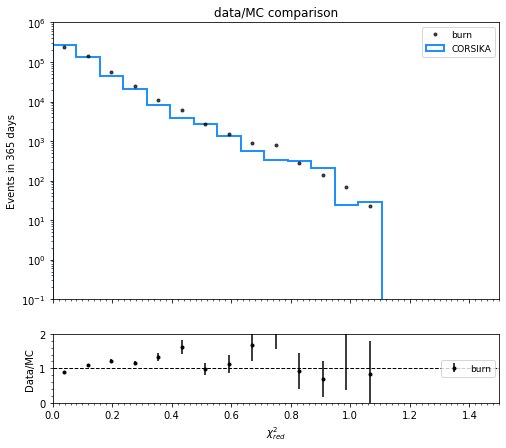

In [12]:
plt.figure(figsize=(8,7))

gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax1 = plt.subplot(gs[0])

h,b,p = plt.hist(chi2_red_corsika,bins=np.linspace(0,1.5,20),log=True,histtype='step',lw=2,label='CORSIKA',weights=weight_corsika,bottom=10**(-6),color='dodgerblue')
hh,bb = np.histogram(chi2_red_data_burn,bins=np.linspace(0,1.5,20),weights = weight_data_burn)

plt.plot((bb[1:]+bb[:-1])/2,hh,'o',ms=3,alpha=0.7,label='burn',color='black')

def sumw2(h,b,weight,quantity):
    w_2 = []
    for i in range(0,len(b)-1):
        all_weight_in_bin = weight[(b[i]<quantity)&(quantity<b[i+1])]
        w_2.append(np.sum(all_weight_in_bin**2))
    return w_2

err_w = np.sqrt(sumw2(h,b,weight_corsika,chi2_red_corsika))
err_ww = np.sqrt(sumw2(hh,bb,weight_data_burn,chi2_red_data_burn))

plt.ylabel('Events in 365 days')
plt.xlim(0,1.5)
plt.ylim(10**(-1),10**6)
plt.legend(loc='best',prop={'size': 9})
plt.title('data/MC comparison')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(0.02))
ax1.tick_params(labelbottom=False)    

ax2 = plt.subplot(gs[1])

h = h[hh > 0.]
bb = ((bb[1:]+bb[:-1])/2)[hh > 0.]
err_w = err_w[hh>0.]
err_ww = err_ww[hh>0.]
hh = hh[hh > 0.]
yerr = np.sqrt(err_ww**2/h**2 + hh**2/h**4*err_w**2)
plt.errorbar(bb, hh/h, yerr = yerr, fmt='o',ms=3,color='black',label='burn')

plt.axhline(1,ls='--',lw=1,color='black')

plt.xlabel(r'$\chi^2_{red}$')
plt.ylabel('Data/MC')
plt.legend(loc='right',prop={'size': 9})
plt.xlim(0,1.5)
plt.ylim(0,2)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax2.xaxis.set_minor_locator(ticker.MultipleLocator(0.02))
ax2.yaxis.set_major_locator(ticker.MultipleLocator(1.))
ax2.yaxis.set_minor_locator(ticker.MultipleLocator(0.2))

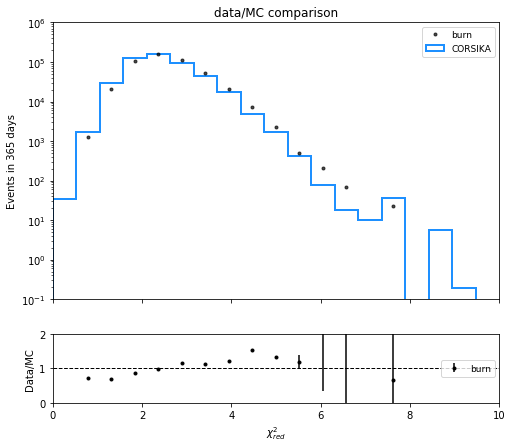

In [13]:
plt.figure(figsize=(8,7))

gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax1 = plt.subplot(gs[0])

h,b,p = plt.hist(np.log10(chi2_red_new_corsika),bins=np.linspace(0,10,20),log=True,histtype='step',lw=2,label='CORSIKA',weights=weight_corsika,bottom=10**(-6),color='dodgerblue')
hh,bb = np.histogram(np.log10(chi2_red_new_data_burn),bins=np.linspace(0,10,20),weights = weight_data_burn)

plt.plot((bb[1:]+bb[:-1])/2,hh,'o',ms=3,alpha=0.7,label='burn',color='black')

def sumw2(h,b,weight,quantity):
    w_2 = []
    for i in range(0,len(b)-1):
        all_weight_in_bin = weight[(b[i]<quantity)&(quantity<b[i+1])]
        w_2.append(np.sum(all_weight_in_bin**2))
    return w_2

err_w = np.sqrt(sumw2(h,b,weight_corsika,chi2_red_new_corsika))
err_ww = np.sqrt(sumw2(hh,bb,weight_data_burn,chi2_red_new_data_burn))

plt.ylabel('Events in 365 days')
plt.xlim(0,10)
plt.ylim(10**(-1),10**6)
plt.legend(loc='best',prop={'size': 9})
plt.title('data/MC comparison')
# ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
# ax1.xaxis.set_minor_locator(ticker.MultipleLocator(0.02))
ax1.tick_params(labelbottom=False)    

ax2 = plt.subplot(gs[1])

h = h[hh > 0.]
bb = ((bb[1:]+bb[:-1])/2)[hh > 0.]
err_w = err_w[hh>0.]
err_ww = err_ww[hh>0.]
hh = hh[hh > 0.]
yerr = np.sqrt(err_ww**2/h**2 + hh**2/h**4*err_w**2)
plt.errorbar(bb, hh/h, yerr = yerr, fmt='o',ms=3,color='black',label='burn')

plt.axhline(1,ls='--',lw=1,color='black')

plt.xlabel(r'$\chi^2_{red}$')
plt.ylabel('Data/MC')
plt.legend(loc='right',prop={'size': 9})
plt.xlim(0,10)
plt.ylim(0,2)
# ax2.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
# ax2.xaxis.set_minor_locator(ticker.MultipleLocator(0.02))
# ax2.yaxis.set_major_locator(ticker.MultipleLocator(1.))
# ax2.yaxis.set_minor_locator(ticker.MultipleLocator(0.2))
plt.show()

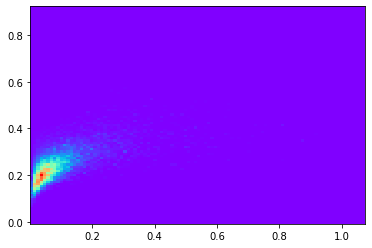

In [27]:
plt.hist2d(chi2_red_corsika,np.log10(chi2_red_new_corsika)/10,bins=100,weights=weight_corsika,cmap='rainbow')
plt.show()

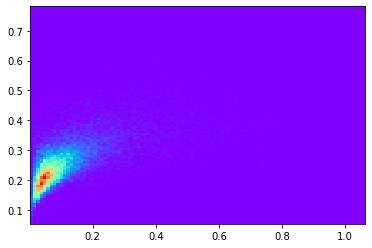

In [28]:
plt.hist2d(chi2_red_data_burn,np.log10(chi2_red_new_data_burn)/10,bins=100,weights=weight_data_burn,cmap='rainbow')
plt.show()